In [24]:
# yelp_clustering_analysis.py
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

INPUT_CSV = "final_real.csv"
OUTPUT_CSV = "final_real_with_clusters.csv"
FIG_FOLDER = "cluster_figs"
os.makedirs(FIG_FOLDER, exist_ok=True)

features = [
    "checkin_count","BusinessAcceptsCreditCards","WiFi","HasTV","BikeParking",
    "OutdoorSeating","RestaurantsPriceRange2","BusinessParking","RestaurantsReservations",
    "Alcohol","GoodForKids","text_count","avg_sentiment","RestaurantsTakeOut",
    "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"
]

df = pd.read_csv(INPUT_CSV)
print("Input shape:", df.shape)

present = [f for f in features if f in df.columns]
missing = [f for f in features if f not in df.columns]
print("Present features:", present)
print("Missing (skipped):", missing)

X = df[present].copy()

num_cols = ["checkin_count","RestaurantsPriceRange2","text_count","avg_sentiment",
            "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"]
for col in num_cols:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

cat_cols = [c for c in ["WiFi","Alcohol","BusinessParking"] if c in X.columns]
for c in cat_cols:
    X[c] = X[c].fillna("missing").astype(str)
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 缺失值以中位数填补
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

K_range = list(range(2,9))
inertia = []
sil = []
print("Chosen k:", best_k)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    # silhouette sampling to save时间（可设为 None 来禁用 sampling）
    s = silhouette_score(X_scaled, labels, sample_size=min(1000, X_scaled.shape[0]), random_state=42)
    sil.append(s)

plt.figure(); plt.plot(K_range, inertia, marker='o'); plt.xlabel("k"); plt.ylabel("Inertia (SSE)");
plt.title("Elbow: Inertia vs k"); plt.savefig(os.path.join(FIG_FOLDER,"elbow_inertia.png")); plt.close()

plt.figure(); plt.plot(K_range, sil, marker='o'); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k");
plt.savefig(os.path.join(FIG_FOLDER,"silhouette.png")); plt.close()

best_k = K_range[int(np.argmax(sil))]
print("Best k (by silhouette):", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
labels = kmeans_final.fit_predict(X_scaled)
df['cluster'] = labels

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for lab in sorted(np.unique(labels)):
    mask = labels == lab
    ax.scatter(X_pca[mask,0], X_pca[mask,1], X_pca[mask,2],
               s=20, label=f"Cluster {lab}", alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D - Clusters (k=4)")
ax.legend()
plt.savefig(os.path.join(FIG_FOLDER,"pca_clusters_3d.png"))
plt.close()

X_imp['cluster'] = labels
cluster_means = X_imp.groupby('cluster').mean()
overall_mean = X_imp.drop(columns='cluster').mean()

cluster_means.to_csv(os.path.join(FIG_FOLDER,"cluster_means.csv"))

cluster_diff = cluster_means - overall_mean
topN = 6
cluster_characteristics = {}
for lab in cluster_diff.index:
    diffs = cluster_diff.loc[lab].sort_values(ascending=False)
    pos = diffs.head(topN)
    neg = diffs.tail(topN)
    cluster_characteristics[lab] = {"top_positive": pos, "top_negative": neg}

labels_map = {}
for lab in cluster_means.index:
    cm = cluster_means.loc[lab]

    high_price =  (cm["RestaurantsPriceRange2"] >= 3)
    alcohol_flag = any([c.startswith("Alcohol_") and cm.get(c, 0) > 0.4 for c in cm.index])
    good_sentiment = (
        cm.get("avg_sentiment", 0) > overall_mean.get("avg_sentiment", 0) + 0.05
    )

    family = ("GoodForKids" in cm.index) and (cm["GoodForKids"] > 0.5)
    parking = any([c.startswith("BusinessParking_") and cm.get(c, 0) > 0.3 for c in cm.index])
    low_price =  (cm["RestaurantsPriceRange2"] < 3)
    strong_service = ("service_sentiment" in cm.index) and (cm["service_sentiment"] > overall_mean.get("service_sentiment", 0))

    lower_price = ("RestaurantsPriceRange2" in cm.index) and (cm["RestaurantsPriceRange2"] <= 2)

    if high_price:
        labels_map[lab] = "High-end Restaurant"
    elif family and parking and strong_service and low_price:
        labels_map[lab] = "Family Restaurant"
    elif lower_price:
        labels_map[lab] = "Fast Food / Convenience"
    else:
        labels_map[lab] = "Other"

cluster_labels_df = pd.DataFrame.from_dict(labels_map, orient='index', columns=['auto_label'])
cluster_labels_df.to_csv(os.path.join(FIG_FOLDER,"cluster_auto_labels.csv"))

df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)
print("Figures & supporting CSV saved into folder:", FIG_FOLDER)

insights = {}
for lab in cluster_means.index:
    name = labels_map[lab]
    pos_features = cluster_characteristics[lab]["top_positive"]
    neg_features = cluster_characteristics[lab]["top_negative"]
    # build a short text paragraph (English or Chinese按需改)
    para = f"Cluster {lab} — {name}:\n"
    para += f"  Sample features above average: {', '.join([f'{idx} ({val:.2f})' for idx,val in pos_features.items()])}.\n"
    para += f"  Sample features below average: {', '.join([f'{idx} ({val:.2f})' for idx,val in neg_features.items()])}.\n"

    if "High-end" in name:
        para += "  Suggestion: focus on premium service, experience-driven marketing, dynamic pricing for peak times.\n"
    elif "Family" in name:
        para += "  Suggestion: family-friendly packages, loyalty offers, emphasize parking/children facilities.\n"
    elif "Takeout" in name:
        para += "  Suggestion: optimize online ordering, delivery packaging, local promotions and menu simplification.\n"
    else:
        para += "  Suggestion: further qualitative inspection required for targeted recommendations.\n"
    insights[lab] = para

with open(os.path.join(FIG_FOLDER,"cluster_insights.txt"), "w", encoding="utf-8") as f:
    for lab, p in insights.items():
        f.write(p + "\n\n")

print("Done. Please inspect the folder and the CSVs. Manually confirm the auto-labels and tweak thresholds as needed.")


Input shape: (4817, 36)
Present features: ['checkin_count', 'BusinessAcceptsCreditCards', 'WiFi', 'HasTV', 'BikeParking', 'OutdoorSeating', 'RestaurantsPriceRange2', 'BusinessParking', 'RestaurantsReservations', 'Alcohol', 'GoodForKids', 'text_count', 'avg_sentiment', 'RestaurantsTakeOut', 'taste_sentiment', 'service_sentiment', 'ambience_sentiment', 'local_cuisine_preference_score']
Missing (skipped): []
Chosen k: 4
Best k (by silhouette): 2
Saved: final_real_with_clusters.csv
Figures & supporting CSV saved into folder: cluster_figs4
Done. Please inspect the folder and the CSVs. Manually confirm the auto-labels and tweak thresholds as needed.


In [24]:
# yelp_clustering_analysis.py
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

INPUT_CSV = "final_real.csv"
OUTPUT_CSV = "final_real_with_clusters.csv"
FIG_FOLDER = "cluster_figs_setK"
os.makedirs(FIG_FOLDER, exist_ok=True)

features = [
    "checkin_count","BusinessAcceptsCreditCards","WiFi","HasTV","BikeParking",
    "OutdoorSeating","RestaurantsPriceRange2","BusinessParking","RestaurantsReservations",
    "Alcohol","GoodForKids","text_count","avg_sentiment","RestaurantsTakeOut",
    "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"
]

df = pd.read_csv(INPUT_CSV)
print("Input shape:", df.shape)

present = [f for f in features if f in df.columns]
missing = [f for f in features if f not in df.columns]
print("Present features:", present)
print("Missing (skipped):", missing)

X = df[present].copy()

num_cols = ["checkin_count","RestaurantsPriceRange2","text_count","avg_sentiment",
            "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"]
for col in num_cols:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

cat_cols = [c for c in ["WiFi","Alcohol","BusinessParking"] if c in X.columns]
for c in cat_cols:
    X[c] = X[c].fillna("missing").astype(str)
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 缺失值以中位数填补
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

best_k = 4   # 三类餐厅 + 其他
print("Chosen k:", best_k)


plt.figure(); plt.plot(K_range, inertia, marker='o'); plt.xlabel("k"); plt.ylabel("Inertia (SSE)");
plt.title("Elbow: Inertia vs k"); plt.savefig(os.path.join(FIG_FOLDER,"elbow_inertia.png")); plt.close()

plt.figure(); plt.plot(K_range, sil, marker='o'); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k");
plt.savefig(os.path.join(FIG_FOLDER,"silhouette.png")); plt.close()

best_k = K_range[int(np.argmax(sil))]
print("Best k (by silhouette):", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
labels = kmeans_final.fit_predict(X_scaled)
df['cluster'] = labels

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for lab in sorted(np.unique(labels)):
    mask = labels == lab
    ax.scatter(X_pca[mask,0], X_pca[mask,1], X_pca[mask,2],
               s=20, label=f"Cluster {lab}", alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D - Clusters (k=4)")
ax.legend()
plt.savefig(os.path.join(FIG_FOLDER,"pca_clusters_3d.png"))
plt.close()

X_imp['cluster'] = labels
cluster_means = X_imp.groupby('cluster').mean()
overall_mean = X_imp.drop(columns='cluster').mean()

cluster_means.to_csv(os.path.join(FIG_FOLDER,"cluster_means.csv"))

cluster_diff = cluster_means - overall_mean
topN = 6
cluster_characteristics = {}
for lab in cluster_diff.index:
    diffs = cluster_diff.loc[lab].sort_values(ascending=False)
    pos = diffs.head(topN)
    neg = diffs.tail(topN)
    cluster_characteristics[lab] = {"top_positive": pos, "top_negative": neg}

labels_map = {}
for lab in cluster_means.index:
    cm = cluster_means.loc[lab]

    high_price =  (cm["RestaurantsPriceRange2"] >= 3)
    alcohol_flag = any([c.startswith("Alcohol_") and cm.get(c, 0) > 0.4 for c in cm.index])
    good_sentiment = (
        cm.get("avg_sentiment", 0) > overall_mean.get("avg_sentiment", 0) + 0.05
    )

    family = ("GoodForKids" in cm.index) and (cm["GoodForKids"] > 0.5)
    parking = any([c.startswith("BusinessParking_") and cm.get(c, 0) > 0.3 for c in cm.index])
    low_price =  (cm["RestaurantsPriceRange2"] < 3)
    strong_service = ("service_sentiment" in cm.index) and (cm["service_sentiment"] > overall_mean.get("service_sentiment", 0))

    lower_price = ("RestaurantsPriceRange2" in cm.index) and (cm["RestaurantsPriceRange2"] <= 2)

    if high_price:
        labels_map[lab] = "High-end Restaurant"
    elif family and parking and strong_service and low_price:
        labels_map[lab] = "Family Restaurant"
    elif lower_price:
        labels_map[lab] = "Fast Food / Convenience"
    else:
        labels_map[lab] = "Other"

cluster_labels_df = pd.DataFrame.from_dict(labels_map, orient='index', columns=['auto_label'])
cluster_labels_df.to_csv(os.path.join(FIG_FOLDER,"cluster_auto_labels.csv"))

df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)
print("Figures & supporting CSV saved into folder:", FIG_FOLDER)

insights = {}
for lab in cluster_means.index:
    name = labels_map[lab]
    pos_features = cluster_characteristics[lab]["top_positive"]
    neg_features = cluster_characteristics[lab]["top_negative"]

    para = f"Cluster {lab} — {name}:\n"
    para += f"  Sample features above average: {', '.join([f'{idx} ({val:.2f})' for idx,val in pos_features.items()])}.\n"
    para += f"  Sample features below average: {', '.join([f'{idx} ({val:.2f})' for idx,val in neg_features.items()])}.\n"

    if "High-end" in name:
        para += "  Suggestion: focus on premium service, experience-driven marketing, dynamic pricing for peak times.\n"
    elif "Family" in name:
        para += "  Suggestion: family-friendly packages, loyalty offers, emphasize parking/children facilities.\n"
    elif "Takeout" in name:
        para += "  Suggestion: optimize online ordering, delivery packaging, local promotions and menu simplification.\n"
    else:
        para += "  Suggestion: further qualitative inspection required for targeted recommendations.\n"
    insights[lab] = para

with open(os.path.join(FIG_FOLDER,"cluster_insights.txt"), "w", encoding="utf-8") as f:
    for lab, p in insights.items():
        f.write(p + "\n\n")

print("Done. Please inspect the folder and the CSVs. Manually confirm the auto-labels and tweak thresholds as needed.")


Input shape: (4817, 36)
Present features: ['checkin_count', 'BusinessAcceptsCreditCards', 'WiFi', 'HasTV', 'BikeParking', 'OutdoorSeating', 'RestaurantsPriceRange2', 'BusinessParking', 'RestaurantsReservations', 'Alcohol', 'GoodForKids', 'text_count', 'avg_sentiment', 'RestaurantsTakeOut', 'taste_sentiment', 'service_sentiment', 'ambience_sentiment', 'local_cuisine_preference_score']
Missing (skipped): []
Chosen k: 4
Best k (by silhouette): 2
Saved: final_real_with_clusters.csv
Figures & supporting CSV saved into folder: cluster_figs4
Done. Please inspect the folder and the CSVs. Manually confirm the auto-labels and tweak thresholds as needed.


PCA explained variance ratio: [0.23122947 0.10881301 0.08093948]
Silhouette Score: 0.12806659702766196


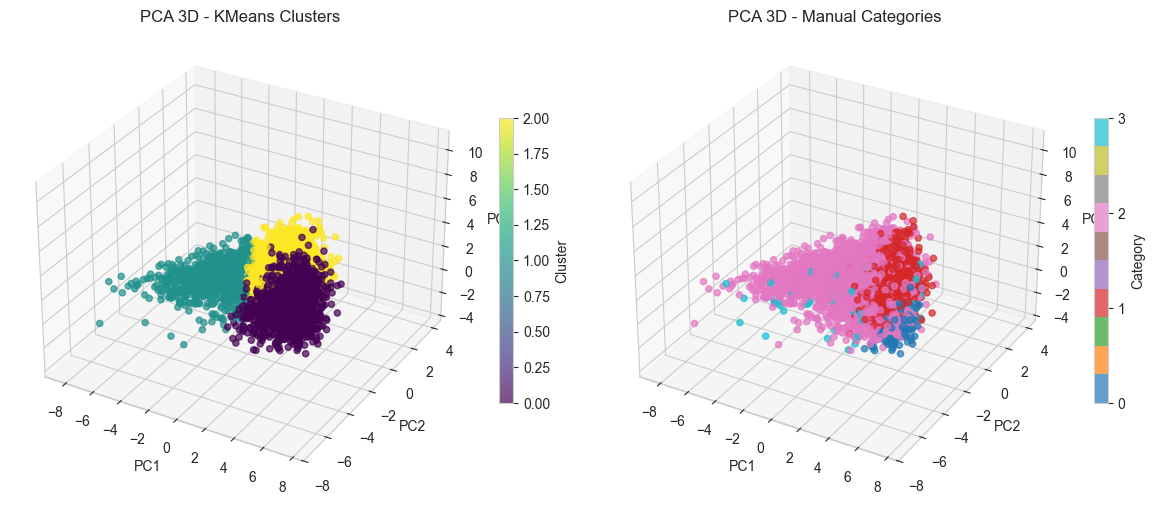

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv("/Users/emmali/PyCharmMiscProject/final_real.csv")

features = ["checkin_count", "BusinessAcceptsCreditCards", "WiFi","HasTV",
            "BikeParking","OutdoorSeating", "RestaurantsPriceRange2","BusinessParking",
            "RestaurantsReservations","Alcohol", "GoodForKids", "text_count",
            "avg_sentiment","RestaurantsTakeOut","taste_sentiment",
            "service_sentiment","ambience_sentiment","local_cuisine_preference_score"]

X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def classify_restaurant(row):

    if row["RestaurantsPriceRange2"] >= 3 and row["Alcohol"] > 0 and row["service_sentiment"] > 0.5 and row["ambience_sentiment"] > 0.5:
        return "High-end"

    elif row["GoodForKids"] > 0 and row["BusinessParking"] > 0 and row["service_sentiment"] > 0.5:
        return "Family"

    elif row["RestaurantsPriceRange2"] <= 2:
        return "Fast-food"
    else:
        return "Other"

df["Category"] = df.apply(classify_restaurant, axis=1)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df["Cluster"] = clusters

silhouette_avg = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", silhouette_avg)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=clusters, cmap='viridis', alpha=0.7)
ax.set_title("PCA 3D - KMeans Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(sc, ax=ax, shrink=0.5, label="Cluster")

ax2 = fig.add_subplot(122, projection='3d')
categories = {"High-end":0, "Family":1, "Fast-food":2, "Other":3}
colors = df["Category"].map(categories)
sc2 = ax2.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=colors, cmap='tab10', alpha=0.7)
ax2.set_title("PCA 3D - Manual Categories")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
plt.colorbar(sc2, ax=ax2, shrink=0.5, ticks=list(categories.values()), label="Category")

plt.tight_layout()
plt.show()


In [11]:
# yelp_clustering_analysis_fixed3.py
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

INPUT_CSV = "final_real.csv"
OUTPUT_CSV = "final_real_with_clusters.csv"
FIG_FOLDER = "cluster_figs_with_PCA3D"
os.makedirs(FIG_FOLDER, exist_ok=True)

features = [
    "checkin_count","BusinessAcceptsCreditCards","WiFi","HasTV","BikeParking",
    "OutdoorSeating","RestaurantsPriceRange2","BusinessParking","RestaurantsReservations",
    "Alcohol","GoodForKids","text_count","avg_sentiment","RestaurantsTakeOut",
    "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"
]

df = pd.read_csv(INPUT_CSV)
print("Input shape:", df.shape)

present = [f for f in features if f in df.columns]
missing = [f for f in features if f not in df.columns]
print("Present features:", present)
print("Missing (skipped):", missing)

X = df[present].copy()

num_cols = ["checkin_count","RestaurantsPriceRange2","text_count","avg_sentiment",
            "taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"]
for col in num_cols:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

cat_cols = [c for c in ["WiFi","Alcohol","BusinessParking"] if c in X.columns]
for c in cat_cols:
    X[c] = X[c].fillna("missing").astype(str)
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

best_k = 3
print("Chosen k:", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
labels = kmeans_final.fit_predict(X_scaled)
df['cluster'] = labels

sil = silhouette_score(X_scaled, labels, sample_size=min(2000, X_scaled.shape[0]), random_state=42)
print("Silhouette score:", sil)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for lab in sorted(np.unique(labels)):
    mask = labels == lab
    ax.scatter(X_pca[mask,0], X_pca[mask,1], X_pca[mask,2],
               s=20, label=f"Cluster {lab}", alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D - Clusters (k=3)")
ax.legend()
plt.savefig(os.path.join(FIG_FOLDER,"pca_clusters_3d.png"))
plt.close()

X_imp['cluster'] = labels
cluster_means = X_imp.groupby('cluster').mean()
overall_mean = X_imp.drop(columns='cluster').mean()
cluster_means.to_csv(os.path.join(FIG_FOLDER,"cluster_means.csv"))

cluster_diff = cluster_means - overall_mean
topN = 6
cluster_characteristics = {}
for lab in cluster_diff.index:
    diffs = cluster_diff.loc[lab].sort_values(ascending=False)
    pos = diffs.head(topN)
    neg = diffs.tail(topN)
    cluster_characteristics[lab] = {"top_positive": pos, "top_negative": neg}

labels_map = {}
for lab in cluster_means.index:
    cm = cluster_means.loc[lab]

    high_price =  (cm["RestaurantsPriceRange2"] >= 3)
    alcohol_flag = any([c.startswith("Alcohol_") and cm.get(c, 0) > 0.4 for c in cm.index])
    good_sentiment = (
        cm.get("avg_sentiment", 0) > overall_mean.get("avg_sentiment", 0) + 0.05
    )

    family = ("GoodForKids" in cm.index) and (cm["GoodForKids"] > 0.5)
    parking = any([c.startswith("BusinessParking_") and cm.get(c, 0) > 0.3 for c in cm.index])
    low_price =  (cm["RestaurantsPriceRange2"] < 3)
    strong_service = ("service_sentiment" in cm.index) and (cm["service_sentiment"] > overall_mean.get("service_sentiment", 0))

    lower_price = ("RestaurantsPriceRange2" in cm.index) and (cm["RestaurantsPriceRange2"] <= 2)

    if high_price:
        labels_map[lab] = "High-end Restaurant"
    elif family and parking and strong_service and low_price:
        labels_map[lab] = "Family Restaurant"
    elif lower_price:
        labels_map[lab] = "Fast Food / Convenience"
    else:
        labels_map[lab] = "Other"

cluster_labels_df = pd.DataFrame.from_dict(labels_map, orient='index', columns=['auto_label'])
cluster_labels_df.to_csv(os.path.join(FIG_FOLDER,"cluster_auto_labels.csv"))

df.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)
print("Figures & CSV saved into folder:", FIG_FOLDER)

insights = {}
for lab in cluster_means.index:
    name = labels_map[lab]
    pos_features = cluster_characteristics[lab]["top_positive"]
    neg_features = cluster_characteristics[lab]["top_negative"]
    para = f"Cluster {lab} — {name}:\n"
    para += f"  Above avg: {', '.join([f'{idx} ({val:.2f})' for idx,val in pos_features.items()])}.\n"
    para += f"  Below avg: {', '.join([f'{idx} ({val:.2f})' for idx,val in neg_features.items()])}.\n"
    if "High-end" in name:
        para += "  Suggestion: focus on premium service, atmosphere, dynamic pricing.\n"
    elif "Family" in name:
        para += "  Suggestion: launch family packages, emphasize kid-friendly facilities, parking.\n"
    elif "Fast" in name:
        para += "  Suggestion: optimize delivery, simplify menu, local promotions.\n"
    insights[lab] = para

with open(os.path.join(FIG_FOLDER,"cluster_insights.txt"), "w", encoding="utf-8") as f:
    for lab, p in insights.items():
        f.write(p + "\n\n")

print("Done. Inspect the results and refine rules if necessary.")


Input shape: (4817, 36)
Present features: ['checkin_count', 'BusinessAcceptsCreditCards', 'WiFi', 'HasTV', 'BikeParking', 'OutdoorSeating', 'RestaurantsPriceRange2', 'BusinessParking', 'RestaurantsReservations', 'Alcohol', 'GoodForKids', 'text_count', 'avg_sentiment', 'RestaurantsTakeOut', 'taste_sentiment', 'service_sentiment', 'ambience_sentiment', 'local_cuisine_preference_score']
Missing (skipped): []
Chosen k: 3
Silhouette score: 0.13131281296552688
Saved: final_real_with_clusters.csv
Figures & CSV saved into folder: cluster_figs12
Done. Inspect the results and refine rules if necessary.
